# Loan Approval Prediction

## 1 Imports

In [85]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from keras.layers import Dense, InputLayer, BatchNormalization
from keras.models import Sequential  
from keras import Input
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Dataset.csv')

## 2 Exploratory Data Analysis

### 2.1 Explore dataset

In [3]:
print('Shape:', df.shape)
print('Columns:', df.columns)


Shape: (614, 13)
Columns: Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


In [4]:
columns = ['Gender', 'Married', 'Dependents' ,'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

In [5]:
print("Unique Values")
print("================================")
for col in columns:
    print(col + ": " + str(df[col].unique()))


Unique Values
Gender: ['Male' 'Female' nan]
Married: ['No' 'Yes' nan]
Dependents: ['0' '1' '2' '3+' nan]
Education: ['Graduate' 'Not Graduate']
Self_Employed: ['No' 'Yes' nan]
Loan_Amount_Term: [360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]
Credit_History: [ 1.  0. nan]
Property_Area: ['Urban' 'Rural' 'Semiurban']
Loan_Status: ['Y' 'N']


In [6]:
df['Loan_Status'].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

### 2.2 Convert Features to appropriate data types

In [12]:
df = df.drop(columns='Loan_ID')
df['Dependents'].fillna(0, inplace=True)
df['Dependents'] = df['Dependents'].replace({'3+': 3, '0': 0, '1': 1, '2': 2})
df['LoanAmount'].fillna(0, inplace=True)
df['Credit_History'].fillna(0, inplace=True)
df['Self_Employed'].fillna('No', inplace=True)
df.dropna(subset=['Loan_Amount_Term'], inplace=True)
df['Gender'].fillna('Neither', inplace=True)
df.dropna(subset=['Married'], inplace=True)
df['Loan_Status'] = df['Loan_Status'].replace({'Y': 1, 'N': 0})


In [13]:
print("Unique Values")
print("================================")
for col in columns:
    print(col + ": " + str(df[col].unique()))

Unique Values
Gender: ['Male' 'Female' 'Neither']
Married: ['No' 'Yes']
Dependents: [0 1 2 3]
Education: ['Graduate' 'Not Graduate']
Self_Employed: ['No' 'Yes']
Loan_Amount_Term: [360. 120. 240. 180.  60. 300. 480.  36.  84.  12.]
Credit_History: [1. 0.]
Property_Area: ['Urban' 'Rural' 'Semiurban']
Loan_Status: [1 0]


In [15]:
columns_to_encode = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

In [16]:
df_encoded.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Gender_Neither,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0.0,0.0,360.0,1.0,1,False,True,False,True,False,True,False,True,False,False,False,True
1,1,4583,1508.0,128.0,360.0,1.0,0,False,True,False,False,True,True,False,True,False,True,False,False
2,0,3000,0.0,66.0,360.0,1.0,1,False,True,False,False,True,True,False,False,True,False,False,True
3,0,2583,2358.0,120.0,360.0,1.0,1,False,True,False,False,True,False,True,True,False,False,False,True
4,0,6000,0.0,141.0,360.0,1.0,1,False,True,False,True,False,True,False,True,False,False,False,True


In [18]:
print(df_encoded.shape)
df_encoded.info()

(597, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 0 to 613
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Dependents               597 non-null    int64  
 1   ApplicantIncome          597 non-null    int64  
 2   CoapplicantIncome        597 non-null    float64
 3   LoanAmount               597 non-null    float64
 4   Loan_Amount_Term         597 non-null    float64
 5   Credit_History           597 non-null    float64
 6   Loan_Status              597 non-null    int64  
 7   Gender_Female            597 non-null    bool   
 8   Gender_Male              597 non-null    bool   
 9   Gender_Neither           597 non-null    bool   
 10  Married_No               597 non-null    bool   
 11  Married_Yes              597 non-null    bool   
 12  Education_Graduate       597 non-null    bool   
 13  Education_Not Graduate   597 non-null    bool   
 14  Self_Employed_No     

In [25]:
bool_cols = [col for col in df_encoded if df_encoded[col].dtype == np.bool_]

In [26]:
bool_cols

['Gender_Female',
 'Gender_Male',
 'Gender_Neither',
 'Married_No',
 'Married_Yes',
 'Education_Graduate',
 'Education_Not Graduate',
 'Self_Employed_No',
 'Self_Employed_Yes',
 'Property_Area_Rural',
 'Property_Area_Semiurban',
 'Property_Area_Urban']

In [28]:
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 0 to 613
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Dependents               597 non-null    int64  
 1   ApplicantIncome          597 non-null    int64  
 2   CoapplicantIncome        597 non-null    float64
 3   LoanAmount               597 non-null    float64
 4   Loan_Amount_Term         597 non-null    float64
 5   Credit_History           597 non-null    float64
 6   Loan_Status              597 non-null    int64  
 7   Gender_Female            597 non-null    int32  
 8   Gender_Male              597 non-null    int32  
 9   Gender_Neither           597 non-null    int32  
 10  Married_No               597 non-null    int32  
 11  Married_Yes              597 non-null    int32  
 12  Education_Graduate       597 non-null    int32  
 13  Education_Not Graduate   597 non-null    int32  
 14  Self_Employed_No         597 no

### 2.3 Visualise 

<Axes: title={'center': 'Correlation with Response'}, ylabel='Loan Status'>

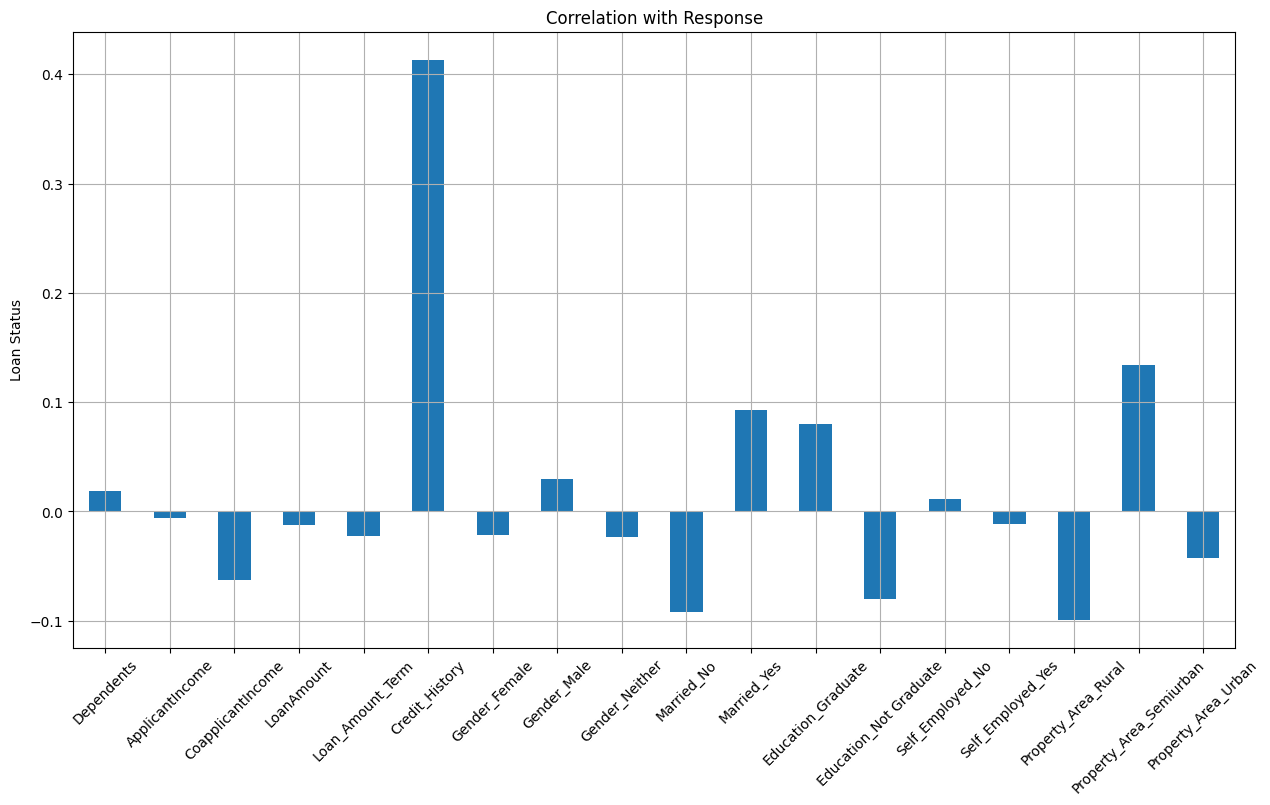

In [34]:
X = df_encoded.drop(columns='Loan_Status')
y = df['Loan_Status']

X.corrwith(y).plot(kind='bar', figsize=(15, 8), rot=45, grid=True, title='Correlation with Response', ylabel='Loan Status')

<Axes: >

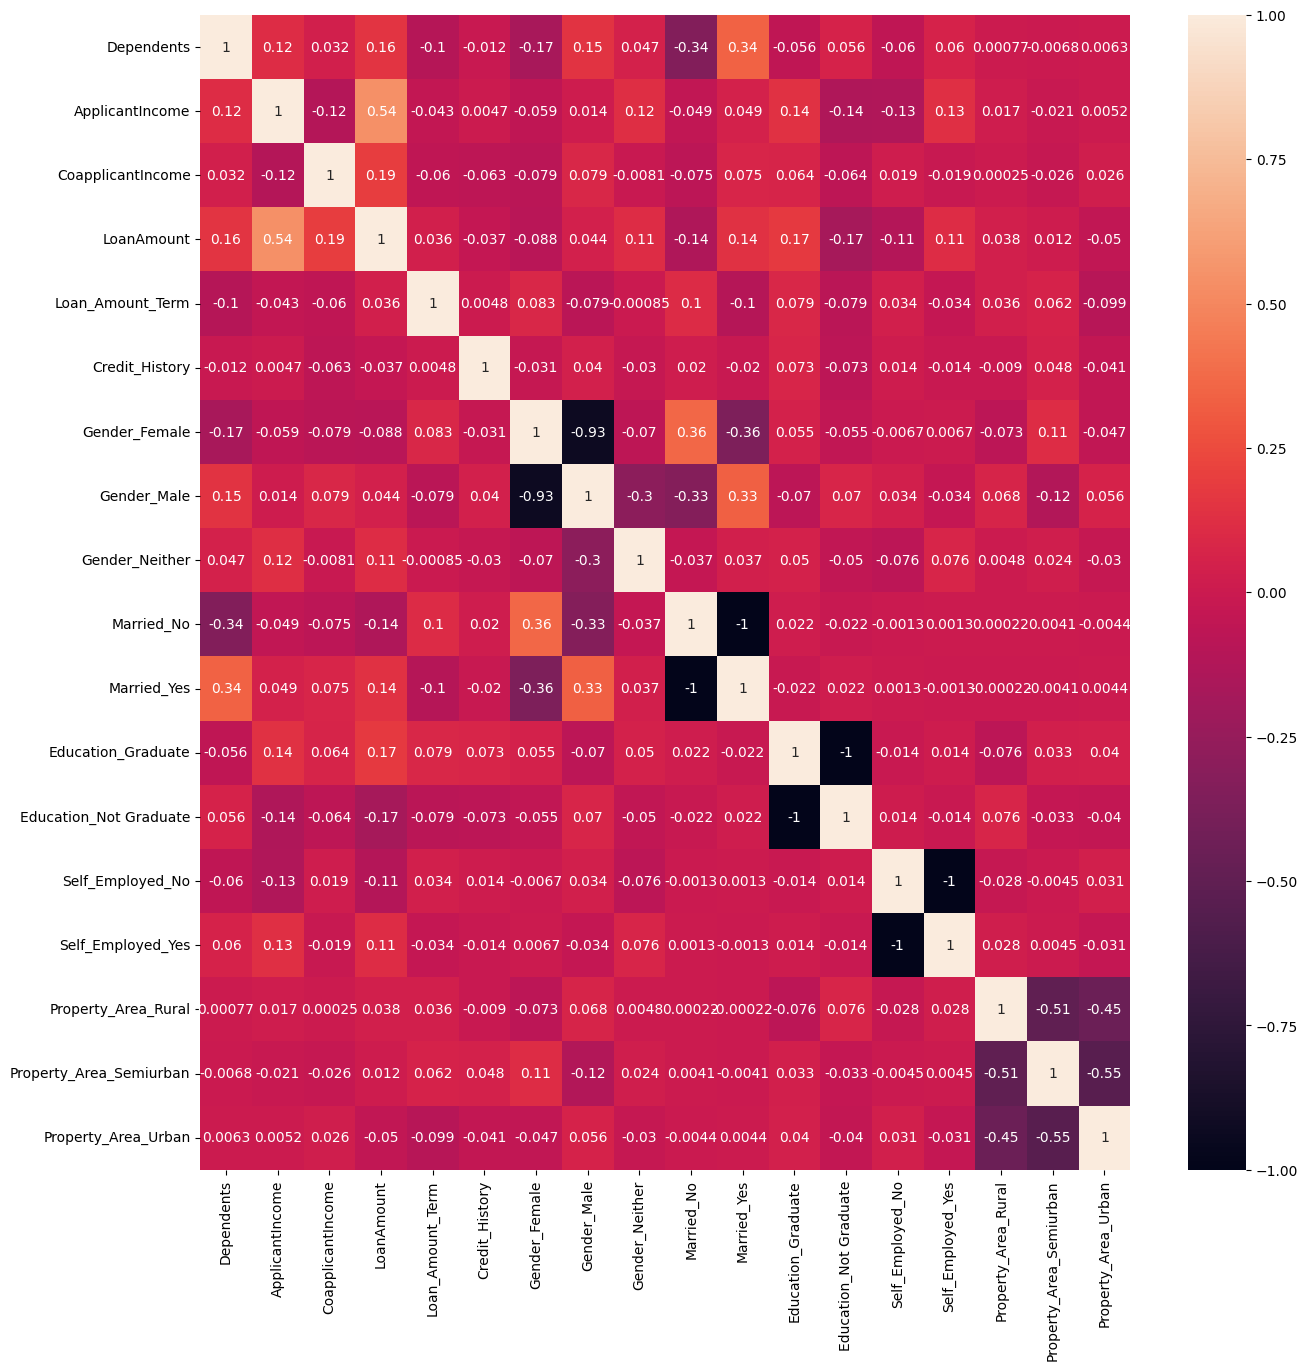

In [37]:
plt.figure(figsize=(15, 15))
sns.heatmap(X.corr(), annot=True)

### 2.4 Imbalance

In [38]:
ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0
)
X_res, y_res = ros.fit_resample(X, y)

In [39]:
print('========Before Oversampling========')
print('X: ', X.shape)
print('y: ', y.shape)
print(y.value_counts())

print('\n=========After Oversampling========')
print('X: ', X_res.shape)
print('y: ', y_res.shape)
print(y_res.value_counts())

========Before Oversampling========
X:  (597, 18)
y:  (597,)
Loan_Status
1    411
0    186
Name: count, dtype: int64

=========After Oversampling========
X:  (822, 18)
y:  (822,)
Loan_Status
1    411
0    411
Name: count, dtype: int64


## 3. Build the Model

### 3.1 Train/Val/Test split

In [86]:
X_temp, X_test, y_temp, y_test = train_test_split(X_res, y_res, stratify=y_res, random_state=42, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=42, test_size=0.25, shuffle=True)

### 3.2 Scale the dataset 

In [87]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns) -> None:
        self.scaler = StandardScaler()
        self.columns = columns 

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self
    
    def transform(self, X):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns, index=X.index)
        X_not_scaled = X.drop(self.columns, axis=1)
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [88]:
columns_to_scale = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

### 3.2 Fit Different Models

#### 3.2.1 Support Vector Machine

In [89]:
param_grid_svc = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [90]:
pipe_svc = Pipeline([('scaler', CustomScaler(columns_to_scale)), ('svm', SVC())])
grid_svc = GridSearchCV(pipe_svc, param_grid=param_grid_svc, cv=5)
grid_svc.fit(X_temp, y_temp)

print("========================SVC=============================")
print(f"Best cross-validation accuracy: {grid_svc.best_score_:.2f}")
print(f"Best parameters: {grid_svc.best_params_}")
print(classification_report(y_temp, grid_svc.predict(X_temp)))
print("========================SVC=============================")

========================SVC=============================
Best cross-validation accuracy: 0.84
Best parameters: {'svm__C': 10, 'svm__gamma': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00       329

    accuracy                           1.00       657
   macro avg       1.00      1.00      1.00       657
weighted avg       1.00      1.00      1.00       657

========================SVC=============================


#### 3.2.2 Logistic Regression

In [91]:
param_grid_lr = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [92]:
pipe_logreg = Pipeline([('scaler', CustomScaler(columns_to_scale)), ('logreg', LogisticRegression())])
grid_lr = GridSearchCV(pipe_logreg, param_grid=param_grid_lr, cv=5)
grid_lr.fit(X_temp, y_temp)


print("========================logreg=============================")
print(f"Best cross-validation accuracy: {grid_lr.best_score_:.2f}")
print(f"Best parameters: {grid_lr.best_params_}")
print(classification_report(y_temp, grid_lr.predict(X_temp)))
print("========================logreg=============================")

========================logreg=============================
Best cross-validation accuracy: 0.68
Best parameters: {'logreg__C': 0.1}
              precision    recall  f1-score   support

           0       0.77      0.62      0.69       328
           1       0.68      0.82      0.74       329

    accuracy                           0.72       657
   macro avg       0.73      0.72      0.72       657
weighted avg       0.73      0.72      0.72       657

========================logreg=============================


#### 3.3.3 Gradient Boosted Classifier

In [93]:
print("===================GradientBoostedClassifier=====================")
print("Training:")
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=3 ,random_state=42)
gbc.fit(X_train, y_train)

print(f"Accuracy on Training set: {gbc.score(X_train, y_train):.2f}")
print(f"Accuracy on Validation set: {gbc.score(X_val, y_val):.2f}")

avg_cv = np.mean(cross_val_score(gbc, X_temp, y_temp, cv=4))
print(f'Average cross-validation score: {avg_cv:.2f}')

print(classification_report(y_train, gbc.predict(X_train)))
print("=================================================================")
print(classification_report(y_val, gbc.predict(X_val)))
print("===================GradientBoostedClassifier=====================")

===================GradientBoostedClassifier=====================
Training:
Accuracy on Training set: 0.91
Accuracy on Validation set: 0.66
Average cross-validation score: 0.74
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       246
           1       0.90      0.92      0.91       246

    accuracy                           0.91       492
   macro avg       0.91      0.91      0.91       492
weighted avg       0.91      0.91      0.91       492

              precision    recall  f1-score   support

           0       0.66      0.66      0.66        82
           1       0.66      0.66      0.66        83

    accuracy                           0.66       165
   macro avg       0.66      0.66      0.66       165
weighted avg       0.66      0.66      0.66       165

===================GradientBoostedClassifier=====================


#### 3.3.4 Random Forest Classifier

In [95]:
print("=====================RandomForestClassifier========================")
print("Training:")
rfc = RandomForestClassifier(n_estimators=100, max_depth=3, n_jobs=-1)
rfc.fit(X_train, y_train)

print(f"Accuracy on Training set: {rfc.score(X_train, y_train):.2f}")
print(f"Accuracy on Validation set: {rfc.score(X_val, y_val):.2f}")

avg_cv = np.mean(cross_val_score(rfc, X_temp, y_temp, cv=4))
print(f'Average cross-validation score: {avg_cv:.2f}')

print(classification_report(y_train, rfc.predict(X_train)))
print("=================================================================")
print(classification_report(y_val, rfc.predict(X_val)))
print("=====================RandomForestClassifier========================")


=====================RandomForestClassifier========================
Training:
Accuracy on Training set: 0.78
Accuracy on Validation set: 0.62
Average cross-validation score: 0.71
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       246
           1       0.78      0.79      0.79       246

    accuracy                           0.78       492
   macro avg       0.78      0.78      0.78       492
weighted avg       0.78      0.78      0.78       492

              precision    recall  f1-score   support

           0       0.63      0.59      0.61        82
           1       0.62      0.66      0.64        83

    accuracy                           0.62       165
   macro avg       0.62      0.62      0.62       165
weighted avg       0.62      0.62      0.62       165

=====================RandomForestClassifier========================


In [109]:
idx = [['SVC', 'SVC', 'Logistic Regression', 'Logistic Regression', 'GradientBoosting', 'GradientBoosting', 'RandomForest', 'RandomForest', 'Neural Network', 'Neural Network'],
       ['Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved']]

columns = ['precision', 'recall', 'f1-score']
data = [[1.00, 1.00, 1.00],
[1.00, 1.00, 1.00],
[0.77, 0.62, 0.69],
[0.68, 0.82, 0.74],
[0.92, 0.89, 0.91],
[0.90, 0.92, 0.91],
[0.79, 0.78, 0.78],
[0.78, 0.79, 0.79],
[0.44, 0.74, 0.55],
[0.92, 0.75, 0.83]]

results = pd.DataFrame(data, index=idx, columns=columns)

mark = results.to_markdown()
print(mark)

|                                         |   precision |   recall |   f1-score |
|:----------------------------------------|------------:|---------:|-----------:|
| ('SVC', 'Not Approved')                 |        1    |     1    |       1    |
| ('SVC', 'Approved')                     |        1    |     1    |       1    |
| ('Logistic Regression', 'Not Approved') |        0.77 |     0.62 |       0.69 |
| ('Logistic Regression', 'Approved')     |        0.68 |     0.82 |       0.74 |
| ('GradientBoosting', 'Not Approved')    |        0.92 |     0.89 |       0.91 |
| ('GradientBoosting', 'Approved')        |        0.9  |     0.92 |       0.91 |
| ('RandomForest', 'Not Approved')        |        0.79 |     0.78 |       0.78 |
| ('RandomForest', 'Approved')            |        0.78 |     0.79 |       0.79 |
| ('Neural Network', 'Not Approved')      |        0.44 |     0.74 |       0.55 |
| ('Neural Network', 'Approved')          |        0.92 |     0.75 |       0.83 |


In [63]:
idx = [['SVC', 'SVC', 'Logistic Regression', 'Logistic Regression', 'GradientBoosting', 'GradientBoosting', 'RandomForest', 'RandomForest'],
       ['Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved']]

columns = ['precision', 'recall', 'f1-score', 'Avg CV accuracy']

data_train = [[1.00, 1.00, 1.00, 0.84],
        [1.00, 1.00, 1.00, 0.84],
        [0.77, 0.62, 0.69, 0.68],
        [0.68, 0.82, 0.74, 0.68],
        [0.66, 0.66, 0.66, 0.74],
        [0.66, 0.66, 0.66, 0.74],
        [0.63, 0.59, 0.61, 0.71],
        [0.62, 0.66, 0.64, 0.71]]


results = pd.DataFrame(data_train, index=idx, columns=columns)
results

precision  recall  f1-score  Avg CV accuracy
SVC                 Not Approved       1.00    0.99      0.99             0.80
                    Approved           0.99    1.00      0.99             0.80
Logistic Regression Not Approved       0.79    0.60      0.68             0.69
                    Approved           0.68    0.84      0.75             0.69
GradientBoosting    Not Approved       0.66    0.66      0.66             0.74
                    Approved           0.66    0.66      0.66             0.74
RandomForest        Not Approved       0.67    0.55      0.60             0.69
                    Approved           0.62    0.73      0.67             0.69

In [83]:
mark = results.to_markdown()
print(mark)

|                                         |   precision |   recall |   f1-score |   Avg CV accuracy |
|:----------------------------------------|------------:|---------:|-----------:|------------------:|
| ('SVC', 'Not Approved')                 |        1    |     0.99 |       0.99 |              0.8  |
| ('SVC', 'Approved')                     |        0.99 |     1    |       0.99 |              0.8  |
| ('Logistic Regression', 'Not Approved') |        0.79 |     0.6  |       0.68 |              0.69 |
| ('Logistic Regression', 'Approved')     |        0.68 |     0.84 |       0.75 |              0.69 |
| ('GradientBoosting', 'Not Approved')    |        0.66 |     0.66 |       0.66 |              0.74 |
| ('GradientBoosting', 'Approved')        |        0.66 |     0.66 |       0.66 |              0.74 |
| ('RandomForest', 'Not Approved')        |        0.67 |     0.55 |       0.6  |              0.69 |
| ('RandomForest', 'Approved')            |        0.62 |     0.73 |       0.67 | 

#### 3.3.5 Neural Network

In [104]:
from sklearn.preprocessing import StandardScaler

X = df_encoded.drop(columns='Loan_Status')
y = df_encoded['Loan_Status']

columns_to_scale = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

scaler = StandardScaler()

X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])


In [105]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, shuffle=True, test_size=0.25)

In [66]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [67]:
model.compile(
    optimizer = 'rmsprop',
    loss = BinaryCrossentropy(),
    metrics = ['accuracy'] 
)

In [68]:
hist = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val)
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6502 - loss: 0.6487 - val_accuracy: 0.7000 - val_loss: 0.6121
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6832 - loss: 0.6095 - val_accuracy: 0.7000 - val_loss: 0.5967
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6753 - loss: 0.6062 - val_accuracy: 0.7000 - val_loss: 0.5847
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7082 - loss: 0.5737 - val_accuracy: 0.7167 - val_loss: 0.5746
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6906 - loss: 0.5859 - val_accuracy: 0.7167 - val_loss: 0.5649
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6961 - loss: 0.5807 - val_accuracy: 0.7083 - val_loss: 0.5576
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7200 - loss: 0.5566 - val_accuracy: 0.7500 - val_loss: 0.5470
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7450 - loss: 0.5678 - val_accuracy: 0.7500 - val_loss

In [69]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [70]:
acc = hist.history['accuracy']
loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

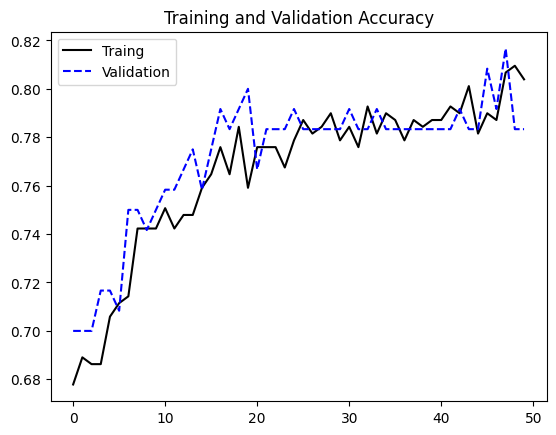

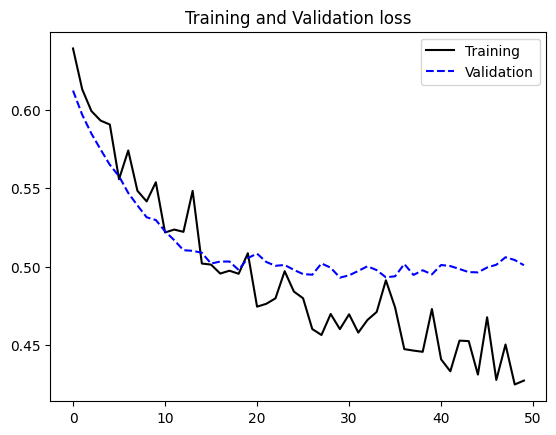

In [76]:
epochs = range(50)

plt.figure()
plt.plot(epochs, acc, 'k', label="Traing")
plt.plot(epochs, val_acc, 'b--', label="Validation")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'k', label="Training")
plt.plot(epochs, val_loss, 'b--', label="Validation")
plt.title("Training and Validation loss")
plt.legend()

In [77]:
y_pred = model.predict(X_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [80]:
y_pred_round = np.round(y_pred)
y_pred_round

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [81]:
print(classification_report(y_pred_round, y_val))

              precision    recall  f1-score   support

         0.0       0.44      0.73      0.55        22
         1.0       0.93      0.80      0.86        98

    accuracy                           0.78       120
   macro avg       0.69      0.76      0.70       120
weighted avg       0.84      0.78      0.80       120



In [106]:
y_pred = model.predict(X_train)
y_pred_round = np.round(y_pred)
print(classification_report(y_pred_round, y_train))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
              precision    recall  f1-score   support

         0.0       0.44      0.74      0.55        74
         1.0       0.92      0.75      0.83       283

    accuracy                           0.75       357
   macro avg       0.68      0.75      0.69       357
weighted avg       0.82      0.75      0.77       357



In [84]:
idx = [['SVC', 'SVC', 'Logistic Regression', 'Logistic Regression', 'GradientBoosting', 'GradientBoosting', 'RandomForest', 'RandomForest', 'NeuralNetwork', 'NeuralNetwork'],
       ['Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved', 'NotApproved', 'Approved']]

columns = ['precision', 'recall', 'f1-score', 'Avg CV accuracy']

data_train = [[1.00, 0.99, 0.99, 0.80],
        [0.99, 1.00, 0.99, 0.80],
        [0.79, 0.60, 0.68, 0.69],
        [0.68, 0.84, 0.75, 0.69],
        [0.66, 0.66, 0.66, 0.74],
        [0.66, 0.66, 0.66, 0.74],
        [0.67, 0.55, 0.60, 0.69],
        [0.62, 0.73, 0.67, 0.69],
        [0.44, 0.73, 0.55, None],
        [0.93, 0.80, 0.86, None]]


results = pd.DataFrame(data_train, index=idx, columns=columns)

mark = results.to_markdown()
print(mark)
print(results)

|                                         |   precision |   recall |   f1-score |   Avg CV accuracy |
|:----------------------------------------|------------:|---------:|-----------:|------------------:|
| ('SVC', 'Not Approved')                 |        1    |     0.99 |       0.99 |              0.8  |
| ('SVC', 'Approved')                     |        0.99 |     1    |       0.99 |              0.8  |
| ('Logistic Regression', 'Not Approved') |        0.79 |     0.6  |       0.68 |              0.69 |
| ('Logistic Regression', 'Approved')     |        0.68 |     0.84 |       0.75 |              0.69 |
| ('GradientBoosting', 'Not Approved')    |        0.66 |     0.66 |       0.66 |              0.74 |
| ('GradientBoosting', 'Approved')        |        0.66 |     0.66 |       0.66 |              0.74 |
| ('RandomForest', 'Not Approved')        |        0.67 |     0.55 |       0.6  |              0.69 |
| ('RandomForest', 'Approved')            |        0.62 |     0.73 |       0.67 | 

In [97]:
idx = [['SVC', 'SVC', 'Logistic Regression', 'Logistic Regression', 'GradientBoosting', 'GradientBoosting', 'RandomForest', 'RandomForest', 'NeuralNetwork', 'NeuralNetwork'],
       ['Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved', 'NotApproved', 'Approved']]

columns = ['precision', 'recall', 'f1-score', 'Avg CV accuracy']

data_train = [[1.00, 1.00, 1.00, 0.84],
        [1.00, 1.00, 1.00, 0.84],
        [0.77, 0.62, 0.69, 0.68],
        [0.68, 0.82, 0.74, 0.68],
        [0.66, 0.66, 0.66, 0.74],
        [0.66, 0.66, 0.66, 0.74],
        [0.63, 0.59, 0.61, 0.71],
        [0.62, 0.66, 0.64, 0.71],
        [0.44, 0.73, 0.55, None],
        [0.93, 0.80, 0.86, None]]

results = pd.DataFrame(data_train, index=idx, columns=columns)

mark = results.to_markdown()
print(mark)
print(results)

|                                         |   precision |   recall |   f1-score |   Avg CV accuracy |
|:----------------------------------------|------------:|---------:|-----------:|------------------:|
| ('SVC', 'Not Approved')                 |        1    |     1    |       1    |              0.84 |
| ('SVC', 'Approved')                     |        1    |     1    |       1    |              0.84 |
| ('Logistic Regression', 'Not Approved') |        0.77 |     0.62 |       0.69 |              0.68 |
| ('Logistic Regression', 'Approved')     |        0.68 |     0.82 |       0.74 |              0.68 |
| ('GradientBoosting', 'Not Approved')    |        0.66 |     0.66 |       0.66 |              0.74 |
| ('GradientBoosting', 'Approved')        |        0.66 |     0.66 |       0.66 |              0.74 |
| ('RandomForest', 'Not Approved')        |        0.63 |     0.59 |       0.61 |              0.71 |
| ('RandomForest', 'Approved')            |        0.62 |     0.66 |       0.64 | 

## 4. Test Models

### 4.1 SVC

In [98]:
print("========================SVC=============================")
print(classification_report(y_test, grid_svc.predict(X_test)))
print("========================SVC=============================")

========================SVC=============================
              precision    recall  f1-score   support

           0       0.99      0.86      0.92        83
           1       0.87      0.99      0.93        82

    accuracy                           0.92       165
   macro avg       0.93      0.92      0.92       165
weighted avg       0.93      0.92      0.92       165

========================SVC=============================


### 4.2 Logistic Regression

In [99]:
print("========================logreg=============================")
print(classification_report(y_test, grid_lr.predict(X_test)))
print("========================logreg=============================")

========================logreg=============================
              precision    recall  f1-score   support

           0       0.78      0.57      0.66        83
           1       0.66      0.84      0.74        82

    accuracy                           0.70       165
   macro avg       0.72      0.70      0.70       165
weighted avg       0.72      0.70      0.70       165

========================logreg=============================


### 4.3 Gradient Boosting 

In [100]:
print("===================GradientBoostedClassifier=====================")
print(classification_report(y_test, gbc.predict(X_test)))
print("===================GradientBoostedClassifier=====================")

===================GradientBoostedClassifier=====================
              precision    recall  f1-score   support

           0       0.77      0.67      0.72        83
           1       0.71      0.79      0.75        82

    accuracy                           0.73       165
   macro avg       0.74      0.73      0.73       165
weighted avg       0.74      0.73      0.73       165

===================GradientBoostedClassifier=====================


### 4.4 Random Forest 

In [101]:
print("=====================RandomForestClassifier========================")
print(classification_report(y_test, rfc.predict(X_test)))
print("=====================RandomForestClassifier========================")

=====================RandomForestClassifier========================
              precision    recall  f1-score   support

           0       0.69      0.63      0.66        83
           1       0.66      0.72      0.69        82

    accuracy                           0.67       165
   macro avg       0.67      0.67      0.67       165
weighted avg       0.67      0.67      0.67       165

=====================RandomForestClassifier========================


In [102]:
y_pred = model.predict(X_test)
y_pred_round = np.round(y_pred)

print("=====================NeuralNetwork========================")
print(classification_report(y_pred_round, y_val))
print("=====================NeuralNetwork========================")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
=====================NeuralNetwork========================
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.66       165
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50       165
   macro avg       0.50      0.25      0.33       165
weighted avg       1.00      0.50      0.66       165

=====================NeuralNetwork========================


In [103]:
idx = [['SVC', 'SVC', 'Logistic Regression', 'Logistic Regression', 'GradientBoosting', 'GradientBoosting', 'RandomForest', 'RandomForest', 'NeuralNetwork', 'NeuralNetwork'],
       ['Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved', 'Not Approved', 'Approved', 'NotApproved', 'Approved']]

columns = ['precision', 'recall', 'f1-score']

data_train = [[0.99, 0.86, 0.92],    
              [0.87, 0.99, 0.93],        
              [0.78, 0.57, 0.66],       
              [0.66, 0.84, 0.74],        
              [0.77, 0.67, 0.72],        
              [0.71, 0.79, 0.75],        
              [0.69, 0.63, 0.66],        
              [0.66, 0.72, 0.69],        
              [1.00, 0.50, 0.66],       
              [0.00, 0.00, 0.00]] 

results = pd.DataFrame(data_train, index=idx, columns=columns)

mark = results.to_markdown()
print(mark)
print(results)

|                                         |   precision |   recall |   f1-score |
|:----------------------------------------|------------:|---------:|-----------:|
| ('SVC', 'Not Approved')                 |        0.99 |     0.86 |       0.92 |
| ('SVC', 'Approved')                     |        0.87 |     0.99 |       0.93 |
| ('Logistic Regression', 'Not Approved') |        0.78 |     0.57 |       0.66 |
| ('Logistic Regression', 'Approved')     |        0.66 |     0.84 |       0.74 |
| ('GradientBoosting', 'Not Approved')    |        0.77 |     0.67 |       0.72 |
| ('GradientBoosting', 'Approved')        |        0.71 |     0.79 |       0.75 |
| ('RandomForest', 'Not Approved')        |        0.69 |     0.63 |       0.66 |
| ('RandomForest', 'Approved')            |        0.66 |     0.72 |       0.69 |
| ('NeuralNetwork', 'NotApproved')        |        1    |     0.5  |       0.66 |
| ('NeuralNetwork', 'Approved')           |        0    |     0    |       0    |
                